In [2]:
import numpy as np
from scipy.integrate import simpson
from nozzle import Spectral, Params, Nozzle, Boundary
import matplotlib.pyplot as plt
from tqdm import tqdm

# Dirichlet boundary

Text(0.5, 1.0, '$v_0=1.5$')

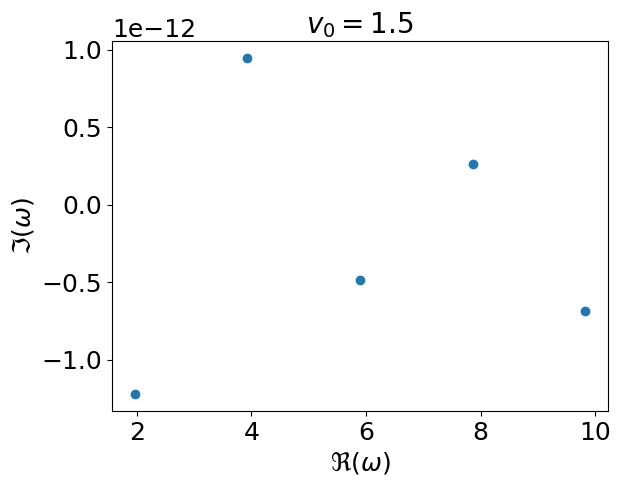

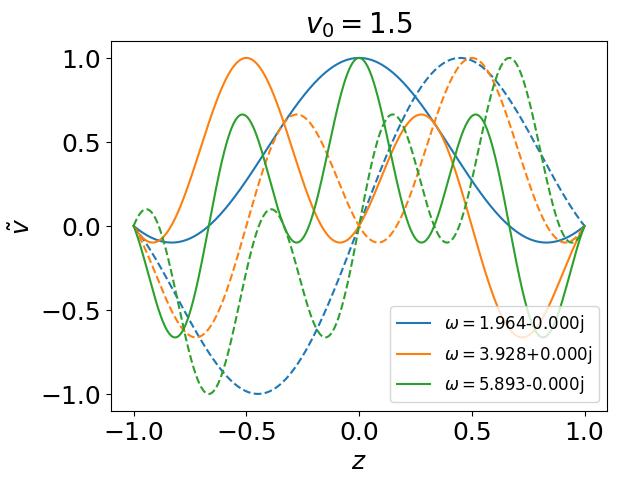

In [16]:
N = 501
Mm = 1.5
constant_v = True
accelerating = True
boundary = Boundary.FIXED_FIXED

params = Params(Mm, constant_v, accelerating, boundary)
spectral = Spectral(N, "symmetric", "FD")
nozzle = Nozzle(params, spectral.x)
v0 = nozzle.v0
x = spectral.x
D1 = spectral.D1
D2 = spectral.D2

A11 = np.zeros_like(D1)
A12 = np.eye(*D1.shape)
A21 = -np.diag(1-v0**2)@D2 \
        + np.diag((3*v0 + 1/v0)*(D1@v0))@D1 \
        + np.diag((1-1/v0**2)*(D1@v0)**2) \
        + np.diag((v0+1/v0)*(D2@v0))
A22 = -2j*(np.diag(v0)@D1 + np.diag(D1@v0))

A = np.block([[A11[1:-1,1:-1], A12[1:-1,1:-1]],[A21[1:-1,1:-1], A22[1:-1,1:-1]]])
V, nozzle.omega = nozzle.solve(A)
nozzle.V = np.pad(V, ((1,1),(0,0))) # pad two ends by 0
nozzle.sort_solutions(real_range=[0,10], imag_range=[-2,2])
ax1 = nozzle.plot_eigenvalues()
ax1.set_title("$v_0=1.5$")
ax2 = nozzle.plot_eigenfunctions()
# ax2.legend(bbox_to_anchor=(1,1))
ax2.legend(fontsize="large", loc="lower right")
ax2.set_title("$v_0=1.5$")

# nozzle.save_data("FD",N=N)

# Open right end 
Since the right end point is open, so the boundary point is constraint by interior points 
$$
0 = v_{n+1}' = \frac{3v_{n+1}-4v_n + v_{n-1}}{2h}
\Rightarrow
v_{n+1} = \frac{4}{3}v_n - \frac{1}{3}v_{n-1}
$$

This indicates that the derivatives at the last interior point should be modified as follows:
$$
v_{n}' = \frac{v_{n+1}-v_{n-1}}{2h} = \frac{1}{2h}\left(\frac{4}{3}v_{n} - \frac{4}{3}v_{n-1}\right) 
$$
$$
v_{n}'' = \frac{v_{n+1}-2v_{n}+v_{n-1}}{h^2} = \frac{1}{h^2}\left(-\frac{2}{3}v_{n} + \frac{2}{3}v_{n-1}\right) 
$$

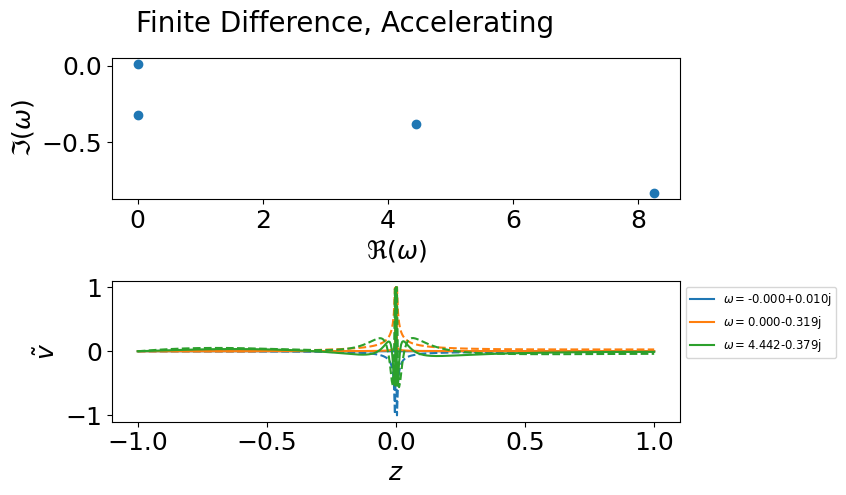

In [29]:
N = 501
Mm = 1.0
constant_v = False
accelerating = True
boundary = Boundary.FIXED_OPEN

params = Params(Mm, constant_v, accelerating, boundary)
spectral = Spectral(N, "symmetric", "FD")
nozzle = Nozzle(params, spectral.x)
v0 = nozzle.v0
x = spectral.x
dx = x[1] - x[0]
D1 = spectral.D1
D2 = spectral.D2
D1v = D1
D2v = D2
D1v[-2,:] = 0
D1v[-2,-3:-1] = np.array([-4/3, 4/3])/dx
D2v[-2,:] = 0
D2v[-2,-3:-1] = np.array([2/3, -2/3])/dx**2

A11 = np.zeros_like(D1)
A12 = np.eye(*D1.shape)
A21 = -np.diag(1-v0**2)@D2v \
        + np.diag((3*v0 + 1/v0)*(D1@v0))@D1v \
        + np.diag((1-1/v0**2)*(D1@v0)**2) \
        + np.diag((v0+1/v0)*(D2@v0))
A22 = -2j*(np.diag(v0)@D1v + np.diag(D1@v0))

A = np.block([[A11[1:-1,1:-1], A12[1:-1,1:-1]],[A21[1:-1,1:-1], A22[1:-1,1:-1]]])
V, nozzle.omega = nozzle.solve(A)
V = np.pad(V, ((1,1),(0,0))) # pad two ends by 0
V[-1,:] = (4*V[-2,:] - V[-3,:])/3 # modify the last row
nozzle.V = V
nozzle.sort_solutions(real_range=[-0.1,50], imag_range=[-1,1])

fig, ax = plt.subplots(2,1, figsize=(7,5))
nozzle.plot_eigenvalues(ax=ax[0])
nozzle.plot_eigenfunctions(num_funcs=3,ax=ax[1])
ax[1].legend(fontsize="small", bbox_to_anchor=(1,1))
fig.suptitle(f"Finite Difference, Accelerating")
plt.tight_layout()

# nozzle.save_data("FD",N=N)